In [6]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from datetime import datetime
import time
from scipy import signal

from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, MultilabelAccuracy
import audiomentations
from torch.utils.data import default_collate
from torchvision.transforms import v2
import timm

from src.audio_utils import play_audio, plot_specgram, plot_waveform
from src.data import AudioDataset, FrequencyMaskingAug, TimeMaskingAug, CutMix, MixUp
from src.data_utils import get_metadata, get_fold, get_metadata_from_csv, get_full_data
from src.train_utils import FocalLoss, BCEFocal2WayLoss, get_cosine_schedule_with_warmup, wandb_init, train_one_epoch, eval_one_epoch
from src.models import AudioGeMSEDClassifier
from src.utils import score_np, roc_auc

import ast
import wandb
import yaml

### Config

In [7]:
class Config:
    start_idx = 'first'
    use_1_peak = False
    peak_filter = 'gaussian'
    use_peaks = True
    peaks_rel_thresh = 0.25
    duration = 15 # 10

    sample_rate = 32000
    target_length = 300 # 500
    n_mels = 96
    n_fft = 1024
    window = 160 # 160
    audio_len = duration*sample_rate
    #hop_length = audio_len // (target_length-1)
    hop_length = 64
    fmin = 50
    fmax = 16000
    top_db = 80
    
    n_classes = 182
    batch_size = 10
    num_epochs = 8
    Model = AudioGeMSEDClassifier
    model_name = 'mn20_as'  # dymn10_as mn20_as tf_efficientnetv2_s
    load_pretrained = None
    n_channels = 1
    n_folds = 5
    upsample_thr = 25
    min_samples_per_class = 50
    use_class_weights = False   # Test

    standardize = False
    dataset_mean = [-22.9137]
    dataset_std = [11.8739]

    data_aug = True     # Test     
    cutmix_mixup = True     # Test
    loss = 'crossentropy'    # Test ('crossentropy', 'bce')
    label_smoothing = 0.0  # Only with crossentropy

    secondary_labels_weight = 0.3   # Test (0)
    use_focal = False    # Test (only with bce)
    use_2wayfocal = False
    focal_gamma = 2
    focal_lambda = 1

    warmup_epochs = 1
    lr = 1e-3
    start_lr = 0.001 # relative to lr
    final_lr = 0.001
    weight_decay = 0.0001
    max_grad_norm = 10

    date = datetime.now().strftime("%m-%d_%H-%M")
    run_name = f"{date}_{n_mels}x{target_length}_{model_name}"
    exp_name = "sample_name"

    base_dir = ''
    short_noises = 'data/background/esc50/use_label'
    background_noises = ['data/background/aicrowd2020_noise_30sec/noise_30sec',
                         'data/background/ff1010bird_nocall/nocall',
                         #'data/background/train_soundscapes/nocall'
                        ]

train_df, class_weights = get_full_data('data', Config.upsample_thr, min_thr=Config.min_samples_per_class)

Num Train: 22314, 101 classes


### Dataset

In [13]:
# Data transforms and augmentations
waveform_transforms = audiomentations.Compose([
    audiomentations.Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
    audiomentations.SevenBandParametricEQ(min_gain_db=-12., max_gain_db=12., p=0.2),
    audiomentations.AirAbsorption(min_temperature=10, max_temperature=20, min_humidity=30, max_humidity=90,
                                  min_distance=10, max_distance=100, p=0.8), 

    audiomentations.OneOf([
        audiomentations.Gain(min_gain_db=-4., max_gain_db=4., p=1), 
        audiomentations.GainTransition(min_gain_db=-12., max_gain_db=3., p=1)
    ], p=0.5),

    audiomentations.OneOf([
        audiomentations.AddGaussianSNR(min_snr_db=5., max_snr_db=40., p=1.),
        audiomentations.AddColorNoise(min_snr_db=5., max_snr_db=40., min_f_decay=-3.01, max_f_decay=-3.01, p=1.)
    ], p=0.5),

    audiomentations.AddShortNoises(sounds_path=Config.short_noises, min_snr_db=5., max_snr_db=30., 
                               noise_rms='relative_to_whole_input',
                               min_time_between_sounds=2., max_time_between_sounds=8., 
                               noise_transform=audiomentations.PolarityInversion(), p=0.4),
    audiomentations.AddBackgroundNoise(sounds_path=Config.background_noises, min_snr_db=5., max_snr_db=30., 
                                   noise_transform=audiomentations.PolarityInversion(), p=0.4),
                                   
    audiomentations.LowPassFilter(min_cutoff_freq=750., max_cutoff_freq=7500., min_rolloff=12, max_rolloff=24, p=0.5),
    audiomentations.PitchShift(min_semitones=-2.5, max_semitones=2.5, p=0.3)
])

spec_transforms = nn.Sequential(
    FrequencyMaskingAug(0.25, 0.1, Config.n_mels, n_masks=3, mask_mode='mean'),
    TimeMaskingAug(0.25, 0.1, Config.target_length, n_masks=3, mask_mode='mean'),
)

waveform_transforms=None if not Config.data_aug else waveform_transforms
spec_transforms=None if not Config.data_aug else spec_transforms


cutmix_or_mixup = v2.RandomApply([
    v2.RandomChoice([
        CutMix(num_classes=Config.n_classes, alpha=0.5, one_hot_labels=Config.loss=='bce'),
        MixUp(num_classes=Config.n_classes, alpha=0.5, one_hot_labels=Config.loss=='bce')
    ], p=[0.65, 0.35])
], p=0.5)


def mix_collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

def peaks_collate_fn(batch):
    data_list = []
    labels_list = []
    
    for data, labels in batch:
        n_peaks = data.shape[0]
        data_list.append(data)
        for n in range(n_peaks):
            labels_list.append(labels)
    
    # Concatenate all the samples into a single tensor
    batch_data = torch.cat(data_list, dim=0)
    batch_labels = torch.tensor(labels_list)
    
    return batch_data, batch_labels

def peaks_mix_collate_fn(batch):
    return cutmix_or_mixup(*peaks_collate_fn(batch))

if Config.use_peaks:
    collate_fn = peaks_mix_collate_fn if Config.cutmix_mixup else peaks_collate_fn
else:
    collate_fn = mix_collate_fn if Config.cutmix_mixup else None

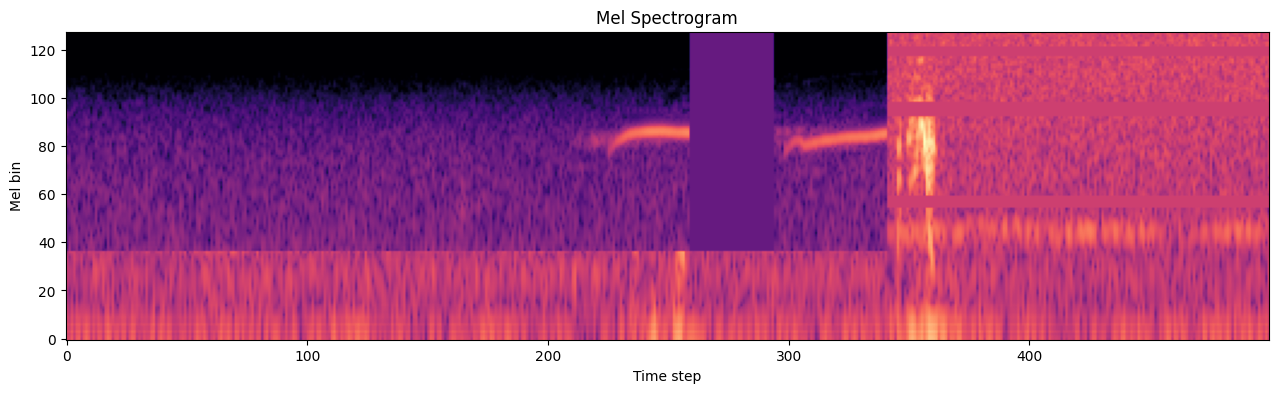

In [14]:
train_dataset = AudioDataset(train_df, Config, waveform_transforms=waveform_transforms, spec_transforms=spec_transforms)
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=8, collate_fn=collate_fn)

spec, label = next(iter(train_loader))

plt.figure(figsize=(16,4))
plt.imshow(spec[0,0], origin='lower', cmap='magma')
plt.grid(visible=False)
plt.title('Mel Spectrogram')
plt.xlabel('Time step')
plt.ylabel('Mel bin')
plt.show()

### Training

In [15]:
device = torch.device('cuda')

# Model and optim
model = Config.Model(Config.n_classes, Config.model_name, n_mels=Config.n_mels).to(device)
if Config.load_pretrained is not None:
    pretrained_checkpoint = torch.load(f"{Config.base_dir}checkpoints/{Config.load_pretrained}/checkpoint.pth", map_location="cpu")
    state_dict = pretrained_checkpoint['model']
    state_dict = {k: v for (k,v) in state_dict.items() if k.startswith('backbone')}
    model.load_state_dict(state_dict, strict=False)
print(f'Model has {sum([p.numel() for p in model.parameters()]):,} parameters')
optimizer = torch.optim.Adam(model.parameters(), weight_decay=Config.weight_decay, lr=Config.lr)
spe = len(train_loader)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=spe*Config.warmup_epochs, num_training_steps=spe*Config.num_epochs, 
                                            start_lr=Config.start_lr, final_lr=Config.final_lr)

# Losses and metrics
pos_weight = torch.tensor(class_weights).to(device) if Config.use_class_weights else None
if Config.loss == 'crossentropy':
    criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing, weight=pos_weight)
elif Config.loss == 'bce':
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, weight=None)

focal_criterion = FocalLoss(gamma=Config.focal_gamma, pos_weight=pos_weight)
focal2way_criterion = BCEFocal2WayLoss(gamma=Config.focal_gamma, pos_weight=pos_weight)

# Start training
start_time = time.time()

save_dir = f"{Config.base_dir}checkpoints/{Config.run_name}" + f"_exp-{Config.exp_name}"
train_losses = []
train_aucs = []

for epoch in range(Config.num_epochs):
    train_loss, gt, preds = train_one_epoch(Config, model, train_loader, device, optimizer, scheduler, 
                                                            criterion, focal_criterion, focal2way_criterion)
    train_losses.append(train_loss)
    train_auc = roc_auc(preds, gt)
    train_aucs.append(train_auc)

    save_dict = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch+1,
        "train_losses": train_losses,
        "train_aucs": train_aucs
    }

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    torch.save(save_dict, save_dir + "/checkpoint.pth")
    if epoch+1 % 10 == 0:
        torch.save(save_dict, save_dir + "/ep10_checkpoint.pth")
    with open(save_dir + "/config.txt", "w") as f:
        f.write("CONFIG:")
        for k,v in dict(vars(Config)).items():
            if '__' not in k:
                f.write("\n")
                f.write(f"{k}: {v}")
    with open(save_dir + "/logs.txt", "a") as f:
        f.write(f"Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Train ROCAUC = {train_auc:.3f}\n")

    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Train ROCAUC = {train_auc:.3f}')


def format_duration(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return "{:02}h {:02}min {:02}s".format(int(hours), int(minutes), int(seconds))

print(f'Done in {format_duration(time.time() - start_time)}')

/home/cedric/miniconda3/envs/birds/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


Features only is true, Dropping final fully-connected layer and loading weights in non-strict mode
Model has 16,033,285 parameters


train loss: 4.443:   4%|▍         | 100/2232 [01:25<30:32,  1.16it/s] 


KeyboardInterrupt: 

In [ ]:
torch.empty_like

# Optimize for inference

In [8]:
import openvino as ov
import nncf

# Load checkpoint
device = torch.device('cpu')

model = Config.Model(Config.n_classes, pretrained=False, model_name=Config.model_name, n_mels=Config.n_mels).to(device)

#save_dir = f"{Config.base_dir}checkpoints/{Config.run_name}"
save_dir = 'checkpoints/06-10_18-06_96x300_mn20_as_exp-lessclasses_peaks_pretrained_gaussianmixupnocw'
checkpoint_name = f'{save_dir}/checkpoint.pth'
checkpoint_ov = f'{save_dir}/checkpoint.xml'
    
checkpoint = torch.load(checkpoint_name, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()
print('loaded')

/home/cedric/miniconda3/envs/birds/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


loaded


In [9]:
# Convert and save model for openvino
input_data = torch.rand(1, Config.n_channels, Config.n_mels, Config.target_length)
ov_model = ov.convert_model(model, example_input=input_data)
ov.save_model(ov_model, save_dir + '/checkpoint.xml')